# Reorganize_and_output_eachpolygon
GeoJSONを最適に区画化してポリゴンごとにクラスタ番号を割り振る

348
farmland: 348
{np.int64(18): np.int64(17), np.int64(47): np.int64(25), np.int64(41): np.int64(97), np.int64(133): np.int64(135), np.int64(51): np.int64(45), np.int64(106): np.int64(104), np.int64(50): np.int64(59), np.int64(56): np.int64(54), np.int64(48): np.int64(42), np.int64(108): np.int64(2), np.int64(126): np.int64(129), np.int64(60): np.int64(17), np.int64(61): np.int64(70), np.int64(128): np.int64(33), np.int64(63): np.int64(68), np.int64(27): np.int64(31), np.int64(127): np.int64(100), np.int64(130): np.int64(131), np.int64(45): np.int64(44), np.int64(83): np.int64(52), np.int64(85): np.int64(75), np.int64(25): np.int64(46), np.int64(86): np.int64(53), np.int64(7): np.int64(103), np.int64(34): np.int64(122), np.int64(49): np.int64(53), np.int64(65): np.int64(52), np.int64(67): np.int64(90), np.int64(132): np.int64(115), np.int64(71): np.int64(72), np.int64(3): np.int64(6), np.int64(74): np.int64(59), np.int64(92): np.int64(102), np.int64(107): np.int64(137), np.int64(104):

/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_87929/591210891.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_clusters).colors  # カラーマップを使用


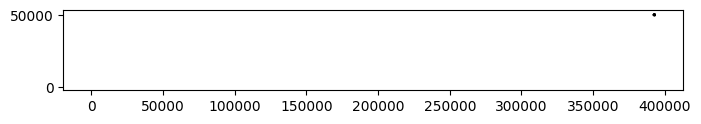

保存しました: ../data/part/


In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors
from shapely.ops import voronoi_diagram

def load_geojson(file_path):
    data =gpd.read_file(file_path)
    print(len(data))
    return data

def estimate_eps(farmland):
    """適切な eps を推定する（農地の距離分布から計算）"""
    centroids = np.array([geom.centroid.coords[0] for geom in farmland.geometry])
    from scipy.spatial import distance_matrix
    dist_matrix = distance_matrix(centroids, centroids)
    np.fill_diagonal(dist_matrix, np.inf)  # 自分自身を除外
    min_dists = np.min(dist_matrix, axis=1)
    return np.percentile(min_dists, 75)  # 75パーセンタイルの距離を eps にする

def split_largest_cluster(grouped, target_n):
    """クラスタ数が target_n より少ない場合、大きなクラスタを分割"""
    while len(grouped) < target_n:
        largest_idx = grouped.area.idxmax()
        largest_poly = grouped.loc[largest_idx].geometry

        # 重心を基に Voronoi 分割
        points = [largest_poly.centroid]
        for _ in range(2):  # 2分割する
            new_point = largest_poly.representative_point()
            points.append(new_point)

        voronoi_regions = voronoi_diagram(MultiPolygon([largest_poly]), [p for p in points])
        new_polys = [r.intersection(largest_poly) for r in voronoi_regions.geoms]

        # 分割後のポリゴンを追加
        new_geos = [p for p in new_polys if isinstance(p, Polygon)]
        grouped = grouped.drop(largest_idx)
        new_df = gpd.GeoDataFrame(geometry=new_geos)
        grouped = pd.concat([grouped, new_df]).reset_index(drop=True)
    return grouped

def cluster_farmland(farmland, target_n):
    """農地をクラスタリングして、target_n 個のクラスタに分割する

    Args:
        farmland (GeoDataFrame): 農地の GeoDataFrame
        target_n (int): 分割後のクラスタ数

    Returns:
        GeoDataFrame: クラスタリング結果
    """
    # 重心を基にクラスタリング
    print("farmland: "+str(len(farmland)))
    farmland = farmland.to_crs(epsg=6674)  # 座標系を投影に
    centroids = np.array([geom.centroid.coords[0] for geom in farmland.geometry])
    eps_value = estimate_eps(farmland)  # 自動的に eps を決定

    # DBSCAN を使用して隣接する農地をクラスタリング
    clustering = DBSCAN(eps=eps_value, min_samples=1).fit(centroids)
    farmland["cluster"] = clustering.labels_ # クラスタリング結果を追加

    grouped = farmland.dissolve(by="cluster") # dissolve: クラスタごとにまとめる
    # 座標系を投影に

    # クラスタid変更履歴
    change_cluster_id = {}
    # クラスタ数が target_n より多い場合 → 統合
    while len(grouped) > target_n:
        # print(len(grouped))
        smallest_idx = grouped.area.idxmin()
        smallest_poly = grouped.loc[smallest_idx]
        remaining = grouped.drop(smallest_idx)
        nearest_idx = remaining.distance(smallest_poly.geometry).idxmin()
        grouped.loc[nearest_idx, "geometry"] = remaining.loc[nearest_idx].geometry.union(smallest_poly.geometry)
        grouped = grouped.drop(smallest_idx)
        change_cluster_id[smallest_idx] = nearest_idx
    print(change_cluster_id)

    # クラスタ数が target_n より少ない場合 → 分割
    # grouped = split_largest_cluster(grouped, target_n)
    # groupedのタイプはGeoDataFrame

    # クラスタid変更履歴を適用
    for k, v in change_cluster_id.items():
        farmland.loc[farmland["cluster"] == k, "cluster"] = v

    # クラスタidを振り直す
    cluster_id_map = {k: i for i, k in enumerate(farmland["cluster"].unique())}
    farmland["cluster"] = farmland["cluster"].map(cluster_id_map)
    grouped = grouped.reset_index(drop=True)
    return farmland, grouped

# ファイルパス（アップロードされたファイルを使用）
file_path = "../data/geojson_filtered_by_settlement/筑地.geojson"
farmland = load_geojson(file_path)

# グループ数を指定
n = 10  # 例: 10個の区画
clustered_farmland_poly, clustered_farmland_multipoly = cluster_farmland(farmland, n)

# カラーマップの設定
num_clusters = len(clustered_farmland_multipoly)
colors = plt.cm.get_cmap("tab10", num_clusters).colors  # カラーマップを使用

# 結果の可視化
fig, ax = plt.subplots(figsize=(8, 8))
farmland.plot(ax=ax, facecolor="none", edgecolor="blue", linestyle="--")

for idx, (geom, color) in enumerate(zip(clustered_farmland_multipoly.geometry, colors)):
    gpd.GeoSeries([geom]).plot(ax=ax, facecolor=color, edgecolor="black", alpha=0.5, label=f"Cluster {idx}")

# plt.legend()
plt.show()

# 結果を GeoJSON として保存
output_path = "../data/part/"
clustered_farmland_poly.to_file(output_path+"clustered_farmland_witheachpolygon.geojson", driver="GeoJSON")
clustered_farmland_multipoly.to_file(output_path+"clustered_farmland.geojson", driver="GeoJSON")

print(f"保存しました: {output_path}")


In [54]:
for idx, item in zip(clustered_farmland_multipoly.geometry, colors):
    print(item)

[0.12156863 0.46666667 0.70588235 1.        ]
[1.         0.49803922 0.05490196 1.        ]
[0.17254902 0.62745098 0.17254902 1.        ]
[0.83921569 0.15294118 0.15686275 1.        ]
[0.58039216 0.40392157 0.74117647 1.        ]
[0.76862745 0.61176471 0.58039216 1.        ]
[0.96862745 0.71372549 0.82352941 1.        ]
[0.78039216 0.78039216 0.78039216 1.        ]
[0.85882353 0.85882353 0.55294118 1.        ]
[0.61960784 0.85490196 0.89803922 1.        ]


idx: 0 color: [0.12156863 0.46666667 0.70588235 1.        ] geom: MULTIPOLYGON (((392993.4966239167 50172.340109239805, 392986.8696210933 50202.20400116024, 393066.1000383329 50219.580532164284, 393072.3922373893 50187.61116468466, 392993.4966239167 50172.340109239805)), ((392987.60730081826 50202.6516831009, 392981.9156107002 50230.04221600651, 393060.3483256463 50245.92317163534, 393065.5898393575 50220.46496560221, 392987.60730081826 50202.6516831009)), ((393058.5586267229 50252.84110830597, 392979.527944932 50235.83711881579, 392973.9814949677 50259.99197927016, 393053.3671330442 50277.1271311397, 393058.5586267229 50252.84110830597)), ((393049.0379086149 50298.72927820262, 393052.9359242432 50278.442136002595, 392972.1516048002 50261.56151720614, 392968.6356173974 50279.833034587515, 393049.0379086149 50298.72927820262)), ((393041.6574269304 50336.12456455596, 393048.6769107823 50300.00429491543, 392968.97283229005 50281.21409167304, 392960.37007262657 50317.973353002664, 393041.6

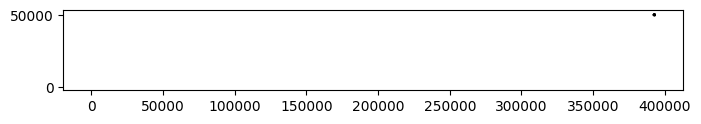

In [55]:
# clustered_farmland_multipolyをmatplotlibで表示
fig, ax = plt.subplots(figsize=(8, 8))
farmland.plot(ax=ax, facecolor="none", edgecolor="blue", linestyle="--")

for idx, (geom, color) in enumerate(zip(clustered_farmland_multipoly.geometry, colors)):
    print("idx: "+str(idx), "color: "+str(color), "geom: "+str(geom))
    gpd.GeoSeries([geom]).plot(ax=ax, facecolor=color, edgecolor="black", alpha=0.5, label=f"Cluster {idx}")

# plt.legend()
plt.show()


In [ ]:
clustered_farmland["cluster_id"] = clustered_farmland.index

In [32]:
clustered_farmland

,geometry,polygon_uuid,land_type,issue_year,edit_year,history,last_polygon_uuid,prev_last_polygon_uuid,local_government_cd,point_lng,...,DaichoId,daicho_shubetsu_cd,CommencementDate,EndStagesDate,UseIntentionInvestigationDate,Settlement_id,Settlement_name,Settlement_pref,Settlement_city,cluster_id
0,"MULTIPOLYGON (((392993.497 50172.34, 392986.87...",845510f7-9879-4fc7-b242-b02d27ef77fd,100,2024,2021,"[ { ""筆ポリゴンID"": ""07bff886-1a8f-4e67-baa9-afbc3a...",07bff886-1a8f-4e67-baa9-afbc3a4ba4b4,83f40c4e-6a7a-491c-9d1f-79d033c9afca,082015,140.378607,...,81009462,KNO01,20180401,20280331,None,006,筑地,茨城県,水戸市,0
1,"MULTIPOLYGON (((392663.088 50465.095, 392742.9...",bc1a920a-51ae-419e-ad96-70e99565ef7f,100,2024,2021,"[ { ""筆ポリゴンID"": ""b3ff9222-f24e-4f07-a8d6-bdabd3...",b3ff9222-f24e-4f07-a8d6-bdabd3a64894,ad4d9799-c4c2-4d10-946d-a8454b6e76d2,082015,140.375484,...,81009523,KNO01,20160520,20260331,None,006,筑地,茨城県,水戸市,1
2,"MULTIPOLYGON (((392608.847 49984.025, 392612.8...",b9b25df0-4216-4c77-b45f-3d4f8f1e310b,100,2024,2020,"[ { ""筆ポリゴンID"": ""390f68b3-d956-4708-b5f9-db4a43...",390f68b3-d956-4708-b5f9-db4a43d81b14,da37b61d-992f-4715-8c07-47f7341d36da,082015,140.374759,...,81009356,KNO01,20160701,20260630,None,006,筑地,茨城県,水戸市,2
3,"MULTIPOLYGON (((392802.168 50619.271, 392815.2...",f698aa22-480c-4a9e-8836-48e23d4e70e8,100,2024,2020,"[ { ""筆ポリゴンID"": ""8010d704-9f3a-49f6-9a39-53cfd1...",8010d704-9f3a-49f6-9a39-53cfd1f7ce99,a356ef22-721c-46f9-bca3-5182f757421a,082015,140.376201,...,81009526,KNO01,None,None,None,006,筑地,茨城県,水戸市,3
4,"MULTIPOLYGON (((392864.079 50349.068, 392859.6...",bf7739ac-7e76-489b-ab47-e03b381ac73e,100,2024,2020,"[ { ""筆ポリゴンID"": ""78b37505-cc16-43ba-ac87-f7ab0c...",78b37505-cc16-43ba-ac87-f7ab0c3ae5b2,42e8e265-616a-4580-a13b-8e32482536e7,082015,140.377562,...,81009469,KNO01,20160701,20260630,None,006,筑地,茨城県,水戸市,4
5,"MULTIPOLYGON (((393153.162 49882.772, 393187.2...",0f31d0cd-fa6f-460d-9075-d480368ae029,100,2024,2020,"[ { ""筆ポリゴンID"": ""66206d29-c3a3-4eae-b4b9-8f8ba8...",66206d29-c3a3-4eae-b4b9-8f8ba8859013,26e3fc77-9102-4dcd-be5f-f13021275411,082015,140.380393,...,81009560,KNO01,20200101,20291231,None,006,筑地,茨城県,水戸市,5
6,"MULTIPOLYGON (((392891.268 49698.169, 392819.7...",e271c767-66e8-4826-9604-88e7e2b678ba,200,2024,2020,"[ { ""筆ポリゴンID"": ""b3ed608c-f6f6-4e20-8b71-2612a6...",b3ed608c-f6f6-4e20-8b71-2612a621157f,baaad857-b8f9-40e6-b2e3-164d286eab41,082015,140.376642,...,81009168,KNO01,None,None,None,006,筑地,茨城県,水戸市,6
7,"MULTIPOLYGON (((392346.326 49676.707, 392339.5...",634cc64a-3c94-4bbd-87c6-2e651dc3fc05,200,2024,2020,"[ { ""筆ポリゴンID"": ""4d8479ab-3312-4a9d-9b28-f527fa...",4d8479ab-3312-4a9d-9b28-f527fa0d4a49,68c92169-40c4-427b-b009-828fb88cef4d,082015,140.371393,...,81009124,KNO01,20171120,20271231,None,006,筑地,茨城県,水戸市,7
8,"MULTIPOLYGON (((392167.026 49978.72, 392214.01...",a3b7a025-6521-45f3-abd0-2e366f2f30e6,100,2024,2020,"[ { ""筆ポリゴンID"": ""72308bd2-9474-447c-8290-86fece...",72308bd2-9474-447c-8290-86fece2f7384,cab5ee9f-7ccc-4367-aa73-4779d0eaffa2,082015,140.369411,...,81009233,KNO01,20180401,20280331,None,006,筑地,茨城県,水戸市,8
9,"MULTIPOLYGON (((392324.121 50059.076, 392315.0...",aafeadbb-6b8c-44ce-8b9f-78a97cdc31eb,100,2024,2020,"[ { ""筆ポリゴンID"": ""7eb74362-fc62-4195-8fb0-10fead...",7eb74362-fc62-4195-8fb0-10feada84acb,ceb9da87-aaa8-4124-82fc-cd6042e3440f,082015,140.370965,...,81009268,KNO01,20191220,20291231,None,006,筑地,茨城県,水戸市,9


In [33]:
for i in range(len(clustered_farmland)):
    print(clustered_farmland.loc[i].geometry)

MULTIPOLYGON (((392993.4966239167 50172.340109239805, 392986.8696210933 50202.20400116024, 393066.1000383329 50219.580532164284, 393072.3922373893 50187.61116468466, 392993.4966239167 50172.340109239805)), ((392987.60730081826 50202.6516831009, 392981.9156107002 50230.04221600651, 393060.3483256463 50245.92317163534, 393065.5898393575 50220.46496560221, 392987.60730081826 50202.6516831009)), ((393058.5586267229 50252.84110830597, 392979.527944932 50235.83711881579, 392973.9814949677 50259.99197927016, 393053.3671330442 50277.1271311397, 393058.5586267229 50252.84110830597)), ((393049.0379086149 50298.72927820262, 393052.9359242432 50278.442136002595, 392972.1516048002 50261.56151720614, 392968.6356173974 50279.833034587515, 393049.0379086149 50298.72927820262)), ((393041.6574269304 50336.12456455596, 393048.6769107823 50300.00429491543, 392968.97283229005 50281.21409167304, 392960.37007262657 50317.973353002664, 393041.6574269304 50336.12456455596)), ((393035.73580104683 50362.47340079

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

# GeoJSONファイルを読み込む
file_path = "./data/geojson_filtered_by_settlement/筑地.geojson"
farmland = gpd.read_file(file_path)

# MultiPolygonをPolygonに分解する関数
def explode_multipolygons(gdf):
    exploded_geometries = []
    for idx, row in gdf.iterrows():
        geom = row.geometry
        if isinstance(geom, MultiPolygon):
            for poly in geom:
                new_row = row.copy()
                new_row.geometry = poly
                exploded_geometries.append(new_row)
        else:
            exploded_geometries.append(row)
    return gpd.GeoDataFrame(exploded_geometries, columns=gdf.columns)

# MultiPolygonを分解
exploded_farmland = explode_multipolygons(farmland)

# 結果を表示
print(exploded_farmland)

# 結果を GeoJSON として保存
output_path = "./data/exploded_farmland.geojson"
exploded_farmland.to_file(output_path, driver="GeoJSON")
print(f"保存しました: {output_path}")

TypeError: 'MultiPolygon' object is not iterable

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from shapely.ops import voronoi_diagram

global plot_counter
plot_counter = 0

def plot_clusters(farmland, title):
    """クラスタリング結果をプロットし、連番の画像として保存"""
    global plot_counter
    fig, ax = plt.subplots(figsize=(8, 8))
    farmland.plot(ax=ax, facecolor="none", edgecolor="blue", linestyle="--")
    num_clusters = len(farmland["cluster"].unique())
    colors = plt.cm.get_cmap("tab20", num_clusters).colors  # カラーマップ設定

    for cluster_id, color in zip(farmland["cluster"].unique(), colors):
        clustered = farmland[farmland["cluster"] == cluster_id]
        clustered.plot(ax=ax, facecolor=color, edgecolor="black", alpha=0.5, label=f"Cluster {cluster_id}")

    plt.title(title)
    plt.legend()
    plt.savefig(f"./data/frames2/clustering_step_{plot_counter}.png")
    plot_counter += 1
    plt.close()

def estimate_eps(farmland):
    centroids = np.array([geom.centroid.coords[0] for geom in farmland.geometry])
    from scipy.spatial import distance_matrix
    dist_matrix = distance_matrix(centroids, centroids)
    np.fill_diagonal(dist_matrix, np.inf)
    min_dists = np.min(dist_matrix, axis=1)
    return np.percentile(min_dists, 75)

def cluster_farmland(farmland, target_n):
    farmland = farmland.to_crs(epsg=6674)
    centroids = np.array([geom.centroid.coords[0] for geom in farmland.geometry])
    eps_value = estimate_eps(farmland)

    clustering = DBSCAN(eps=eps_value, min_samples=1).fit(centroids)
    farmland["cluster"] = clustering.labels_

    plot_clusters(farmland, "Initial Clustering")

    grouped = farmland.dissolve(by="cluster")
    change_cluster_id = {}

    while len(grouped) > target_n:
        smallest_idx = grouped.area.idxmin()
        smallest_poly = grouped.loc[smallest_idx]
        remaining = grouped.drop(smallest_idx)
        nearest_idx = remaining.distance(smallest_poly.geometry).idxmin()
        grouped.loc[nearest_idx, "geometry"] = remaining.loc[nearest_idx].geometry.union(smallest_poly.geometry)
        grouped = grouped.drop(smallest_idx)
        change_cluster_id[smallest_idx] = nearest_idx

        farmland.loc[farmland["cluster"] == smallest_idx, "cluster"] = nearest_idx
        plot_clusters(farmland, f"After Merging Cluster {smallest_idx} into {nearest_idx}")

    cluster_id_map = {k: i for i, k in enumerate(farmland["cluster"].unique())}
    farmland["cluster"] = farmland["cluster"].map(cluster_id_map)

    plot_clusters(farmland, "Final Clustering Result")
    return farmland, grouped

file_path = "./data/geojson_filtered_by_settlement/筑地.geojson"
farmland = gpd.read_file(file_path)
n = 10
clustered_farmland_poly, clustered_farmland_multipoly = cluster_farmland(farmland, n)

# output_path = "./data/clustered_farmland_witheachpolygon.geojson"
# clustered_farmland_poly.to_file(output_path, driver="GeoJSON")
# print(f"保存しました: {output_path}")


/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_77326/2918810339.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", num_clusters).colors  # カラーマップ設定
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_77326/2918810339.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_77326/2918810339.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_77326/291881